# Dimensionality reduction via PCA, kPCA, and LDA


Both Linear Discriminant Analysis (LDA) and Principal Components Analysis (PCA) are linear transformation methods. Kernel PCA (kPCA) first transforms the data with a non-linear kernel, then performs PCA; thus it can find non-linear components.

PCA and kPCA yield the directions (components) in the vector space that maximize the variance of the data. They do not use any supervised labelling. Whereas LDA aims to find the components that maximizes the separation between classes using a set of supervised labels. 

LDA assumes that all classes have different means but the same covariance structure. PCA and kPCA assume that the main source of variance in the data is signal and not noise. Both LDA and PCA assume that a linear transformation of the data space is sufficient to expose important patterns. Make sure your dataset/problem matches these assumptions!

For data which is $ n \times d$, PCA and LDA transform the data into $n \times d$ components. These components are transformations of the original data's vector space. In contrast kPCA transforms the data into an $n \times n$ similarity matrix before calculating its components, so it ends up with $n \times n$ matrix in component space and is much more computationally intensive for large $n$, low $d$ problems.  In all three algorithms we can tranform data from the original data space into the component space and back again. 

Dimensionality reduction is the process of taking a subset of the $d$ (or $n$ for kPCA) components and using them to reconstruct the data.  All three algorithms have a concept of "most useful" components that best describe the optimization criteria of the algorithm, so we wll take only the most useful components in our subset.  For PCA/kPCA that's the components with the largest eigenvalues because they capture the most variance in the data. For LDA that's the components that produce the best posterior probability of correct 
classification. 


## Datasets

I'll load three datasets of this task, penguins, MNIST and a dataset of measurements of normal and cancerous cells. 


In [1]:
# basic data utils
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pal = sns.color_palette("hls", 10)

# Dimension reduction and clustering tools
import sklearn.cluster as cluster
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data loading
from sklearn.datasets import fetch_openml

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Metrics for how good a clustering does
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, classification_report

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

count    70000.000000
mean         4.452429
std          2.890195
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: class, dtype: float64

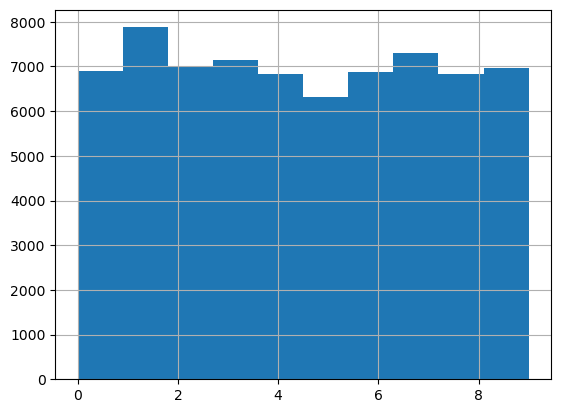

In [3]:
# we should know as much as possible about our datasets... it will influence how we use it

# lets start by seeing something about the distribution of classes
mnist.target.hist();
mnist.target.describe()

NOTE -- Always check if classes are balanced in number

count    5.488000e+07
mean     3.338596e+01
std      7.865437e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.550000e+02
dtype: float64

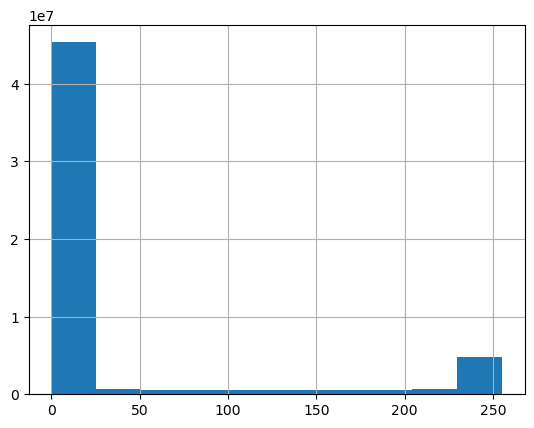

In [4]:
# now lets see something about the distribution of pixel values

# take all pixels in all images, put them in one lump
pix = pd.Series( mnist.data.values.reshape(-1) )

# so we can examine the values of these grayscale pixels
pix.hist()
pix.describe()

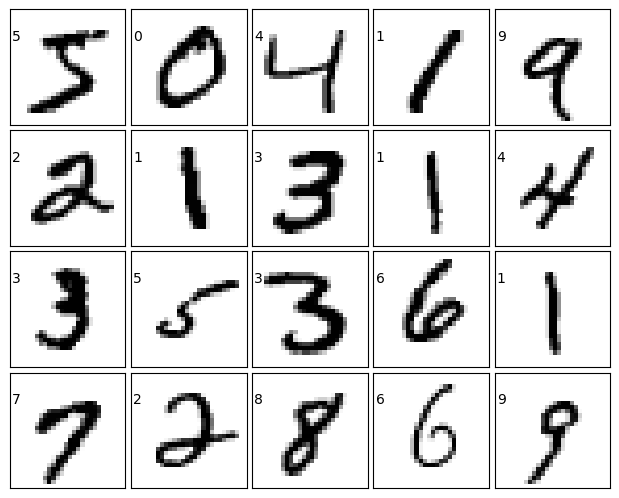

In [5]:
# examples of the raw data

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(mnist.data.loc[i].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(mnist.target.loc[i]))

In [6]:
# lets get some üêß data to work with
penguins = sns.load_dataset("penguins").dropna()
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
4         3450.0  Female  
5         3650.0    Male  
..           ...     ...  
338       4925.0  Female  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[333 rows x 7 columns]

In [7]:
penguins[['species','sex','island']].value_counts()

species    sex     island   
Gentoo     Male    Biscoe       61
           Female  Biscoe       58
Chinstrap  Female  Dream        34
           Male    Dream        34
Adelie     Male    Dream        28
           Female  Dream        27
                   Torgersen    24
           Male    Torgersen    23
           Female  Biscoe       22
           Male    Biscoe       22
dtype: int64

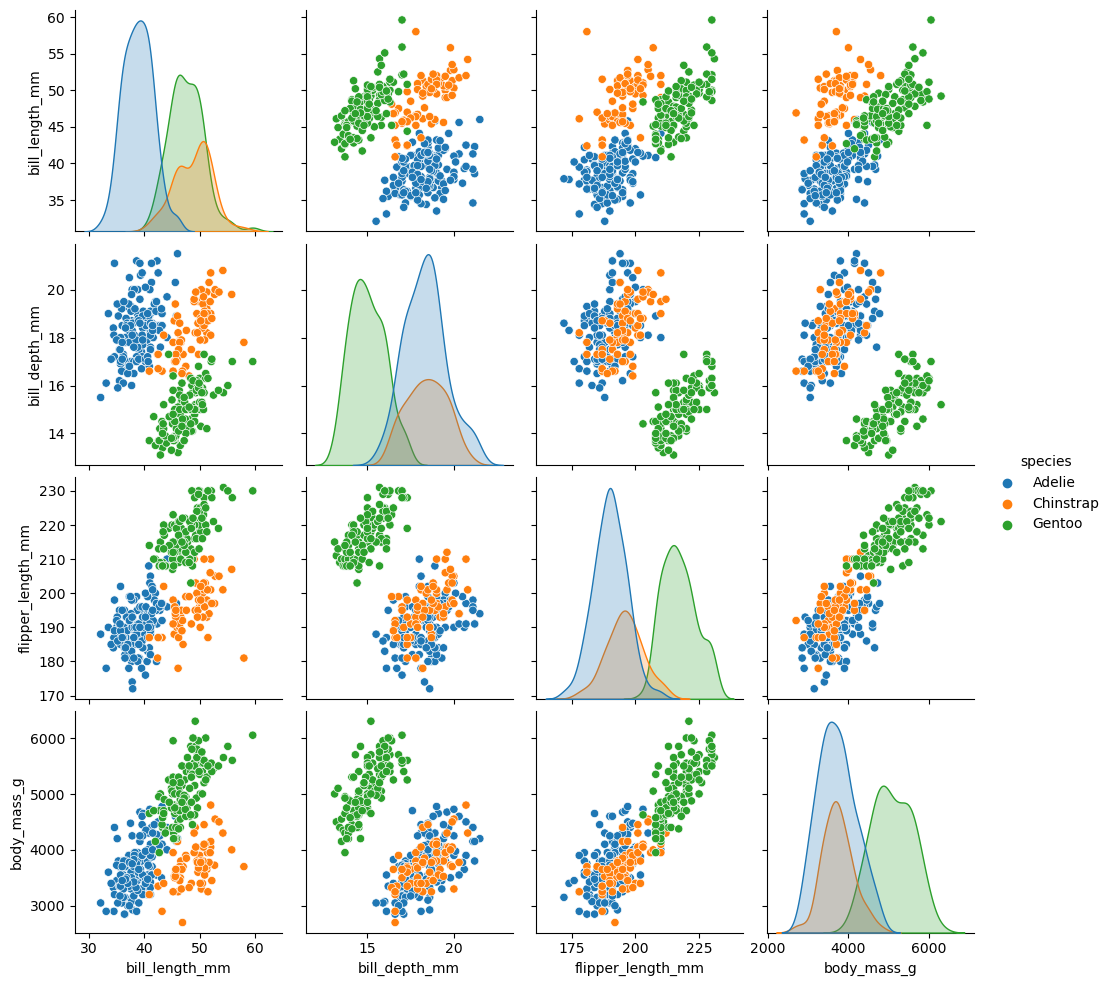

In [8]:
sns.pairplot(penguins,hue='species');

In [9]:
cancer = fetch_openml('Wisconsin-breast-cancer-cytology-features', version=1)
cancer.target = cancer.data['class']
cancer.data = cancer.data.drop(columns='class')

In [10]:
print(cancer.DESCR)

Context
Cytology features of breast cancer biopsy. It can be used to predict breast cancer from cytology features.
The data was obtained from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original) 
Data description can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names
Content
Data contains cytology features of breast cancer biopsies - clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nuceloli, mitosis. The class variable denotes whether it was cancer or not. Cancer = 1 and not cancer = 0
Attribute Information:

Sample code number: id number 
Clump Thickness: 1 - 10 
Uniformity of Cell Size: 1 - 10 
Uniformity of Cell Shape: 1 - 10 
Marginal Adhesion: 1 - 10 
Single Epithelial Cell Size: 1 - 10 
Bare Nuclei: 1 - 10 
Bland Chromatin: 1 - 10 
Normal Nucleoli: 1 - 10 
Mitoses: 1 - 10 
Class: (0 f

In [11]:
cancer.data.drop(columns='id').describe()

thickness        size       shape    adhesion      single      nuclei  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  683.000000   
mean     4.417740    3.134478    3.207439    2.806867    3.216023    3.544656   
std      2.815741    3.051459    2.971913    2.855379    2.214300    3.643857   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      2.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
50%      4.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
75%      6.000000    5.000000    5.000000    4.000000    4.000000    6.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

        chromatin    nucleoli     mitosis  
count  699.000000  699.000000  699.000000  
mean     3.437768    2.866953    1.589413  
std      2.438364    3.053634    1.715078  
min      1.000000    1.000000    1.000000  
25%      2.000000    1.000000    1.000000  
50%      3.000000    1.000000    1.000000  
75%      5.000000    4.000000    1.000000  
max     10.000000   10.000000   10.000000

In [12]:
# some people are in the dataset more than once
# these are so called technical replicates... multiple measurements of the same persons cells
print(cancer.data.id.unique().shape[0],'unique people in the raw dataset')

# but lets get rid of them anyway to make our lives easier
cancer.data = cancer.data.drop_duplicates(subset=['id'])

645 unique people in the raw dataset


In [13]:
cancer.data.shape

(645, 10)

## Tasks

Lets use some or all of those datasets to explore the following

1. PCA / kPCA / LDA dimensionality reduction to 2 dim for visualization
    - View the PC loadings to analyze what the components are
1. Classification via LDA (which uses all the components in sklearn)
    - cross validation performance
1. Model selection for number of PCs to capture most of the variability
    - in sample: pick the elbow of % variance explained or pick a fixed threshold of % variance explained
1. Clustering on top of the selected number of PCs
    - in sample: as above + BIC (or similar) of clustering model on top
    - grid search cros validation of pipeline params of preproc + dr + clustering
1. Using dimensionality reduction as a novelty/outlier detector
    - train on training set, visualize on test
    
    
### Task 1: visualization

In [47]:
pca = PCA(n_components=2)
kpca = KernelPCA(n_components=2, kernel='linear', gamma=1e-10, degree=3, eigen_solver='randomized') # MUST use this solver for large dataset !!!
lda = LinearDiscriminantAnalysis(n_components=2)
scaler = StandardScaler() # other choices are available!!
onehot = OneHotEncoder()

dataset = mnist.data
target = mnist.target
to_scale = dataset.columns[ dataset.dtypes == float ] # numerical --> scale
to_onehot = dataset.columns[ dataset.dtypes == object ] # categorical --> one hot
scaled = scaler.fit_transform(dataset[to_scale])
cats = onehot.fit_transform(dataset[to_onehot])
print(f'numeric features: {to_scale.shape[0]}\tcategorical features: {to_onehot.shape[0]}')
preproc = pd.DataFrame(scaled, columns=scaler.get_feature_names_out())
preproc = preproc.join( pd.DataFrame(cats.toarray(), 
                            columns=onehot.get_feature_names_out(), 
                            index=preproc.index))
preproc

numeric features: 784	categorical features: 0


pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0          0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
1          0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
2          0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
3          0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
4          0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
...        ...  ...       ...       ...       ...       ...       ...   
69995      0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
69996      0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
69997      0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
69998      0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   
69999      0.0  ... -0.032951 -0.023387  -0.01675 -0.010638 -0.008339   

       pixel780  pixel781  pixel782  pixel783  pixel784  
0     -0.005342       0.0       0.0       0.0       0.0  
1     -0.005342       0.0       0.0       0.0       0.0  
2     -0.005342       0.0       0.0       0.0       0.0  
3     -0.005342       0.0       0.0       0.0       0.0  
4     -0.005342       0.0       0.0       0.0       0.0  
...         ...       ...       ...       ...       ...  
69995 -0.005342       0.0       0.0       0.0       0.0  
69996 -0.005342       0.0       0.0       0.0       0.0  
69997 -0.005342       0.0       0.0       0.0       0.0  
69998 -0.005342       0.0       0.0       0.0       0.0  
69999 -0.005342       0.0       0.0       0.0       0.0  

[70000 rows x 784 columns]

In [48]:
# sklearn pca DOES automatically 0-center inputs but does NOT scale
# note that particularly for kernelPCA we need to sample a subset of the dataset
# because kernelPCA builds a NxN matrix which is very computationally expensive

red = pca.fit_transform(dataset) 
# or try any of the following
# red = pca.fit_transform(preproc)
# red = kpca.fit_transform(dataset.sample(5000)) # adjust subsampling according to dataset!
# red = kpca.fit_transform(preproc.sample(5000)) # adjust subsampling according to dataset!
# red = lda.fit_transform(dataset, target)
# red = lda.fit_transform(preproc, target)


reduced = pd.DataFrame(red, columns=['pc1','pc2']).join(target)
reduced

pc1         pc2  class
0       122.252671 -316.267394      5
1      1010.494682 -289.935307      0
2       -58.993586  393.746763      4
3      -796.967556 -607.482195      1
4      -391.317412  729.844857      9
...            ...         ...    ...
69995   305.691653 -549.691652      2
69996   569.185916 -699.025958      3
69997  -271.507103  590.069417      4
69998  -310.224904 -116.759057      5
69999  1058.861883  -83.382077      6

[70000 rows x 3 columns]

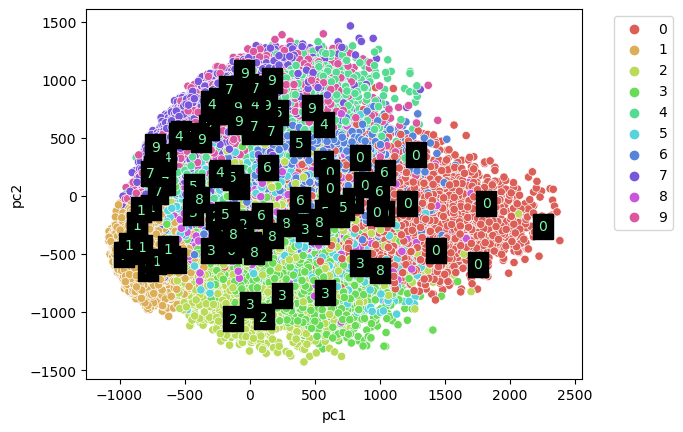

In [49]:
sns.scatterplot(data=reduced, x='pc1', y='pc2', hue='class', palette=pal);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

labelit=True
if labelit:
    np.random.seed(777)
    rsamp = reduced.sample(100)
    for i in range(rsamp.shape[0]):
        # label the image with the target value
        plt.text(rsamp.iloc[i, 0], rsamp.iloc[i, 1], str(rsamp.iloc[i,2]), color='xkcd:seafoam', backgroundcolor='k')


In [50]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1 Loadings', 'PC2 Loadings'])
loadings

PC1 Loadings  PC2 Loadings
0    2.448240e-18 -6.177071e-17
1    5.532097e-18 -9.582789e-17
2   -1.993236e-18 -1.913959e-17
3   -9.736447e-19 -1.255857e-17
4    5.725982e-20 -6.122747e-19
..            ...           ...
779  6.510116e-08  1.900452e-06
780  0.000000e+00  0.000000e+00
781  0.000000e+00  0.000000e+00
782  0.000000e+00  0.000000e+00
783  0.000000e+00  0.000000e+00

[784 rows x 2 columns]

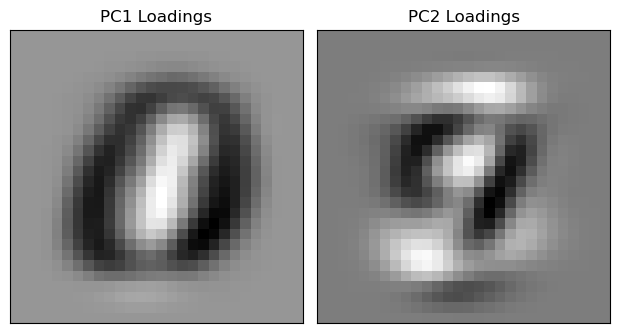

In [51]:
fig = plt.figure(figsize=(6, 3))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(loadings.loc[:,'PC1 Loadings'].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
ax.set_title('PC1 Loadings')

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(loadings.loc[:,'PC2 Loadings'].to_numpy().reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
ax.set_title('PC2 Loadings');


### Task 2: LDA classification

In [54]:
X_train, X_test, y_train, y_test = train_test_split( dataset, target, test_size=0.3, random_state=42)
lda.fit(X_train, y_train)
prediction = lda.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2058
           1       0.86      0.96      0.91      2364
           2       0.91      0.81      0.85      2133
           3       0.85      0.84      0.85      2176
           4       0.84      0.89      0.87      1936
           5       0.83      0.82      0.82      1915
           6       0.93      0.91      0.92      2088
           7       0.93      0.84      0.88      2248
           8       0.80      0.78      0.79      1992
           9       0.79      0.86      0.83      2090

    accuracy                           0.87     21000
   macro avg       0.87      0.87      0.87     21000
weighted avg       0.87      0.87      0.87     21000



Confusion matrix:
[[1940    2    9    5   11   40   23    1   25    2]
 [   0 2266    8   18    2   15    1    3   46    5]
 [  26   81 1723   71   44   15   65   12   89    7]
 [   5   32   58 1833   10   78    7   38   63   52]
 [   1   20   15    0 1728   13    6    1   25  127]
 [  19   24   12  104   20 1561   31   11   97   36]
 [  16   25   31    0   46   44 1908    0   17    1]
 [  15   54   17   20   57    6    0 1891   10  178]
 [  11  126   16   76   24   96   12    3 1556   72]
 [  14   11    9   29  108    8    0   81   23 1807]]


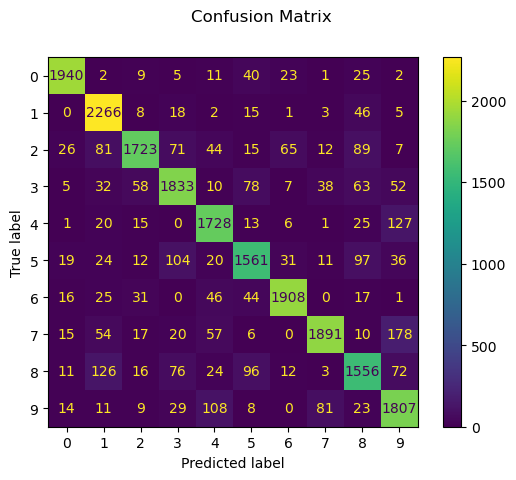

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay 

disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

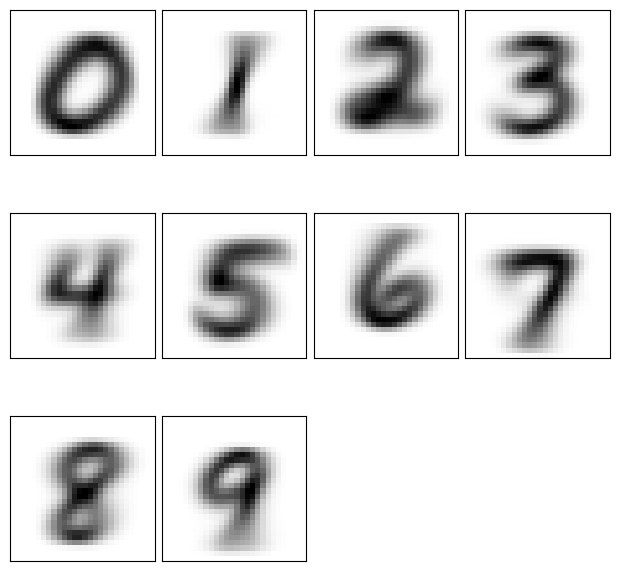

In [244]:
# LDA class means

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    # data is 28 x 28 pixels, grayscale
    ax.imshow(lda.means_[i,:].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    


### Task 3: Select PCs in sample via elbow methods

In [252]:
pca = PCA()
dataset = mnist.data
red = pca.fit_transform(dataset)

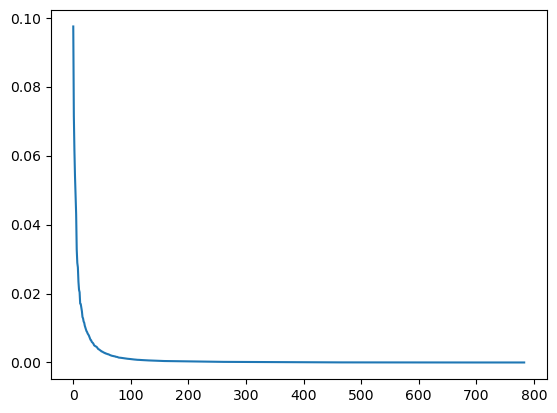

In [257]:
# pca.explained_variance_ is actually the eigenvalues
# pca.explained_variance_ratio_ is actually the % variance explained per eigenvalue
plt.plot(pca.explained_variance_ratio_);  

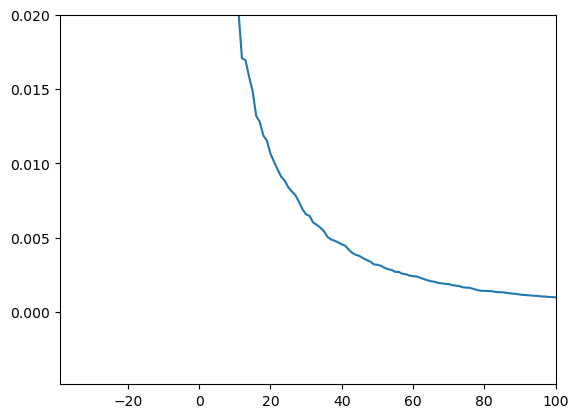

In [258]:
# zoom in on the elbow!!!
plt.plot(pca.explained_variance_ratio_);
plt.xlim(right=100);
plt.ylim(top=0.02);

or you can select by how many components it takes to explain a fixed threshold of total variance

take up to PC 86 to get to 0.9% variance explained


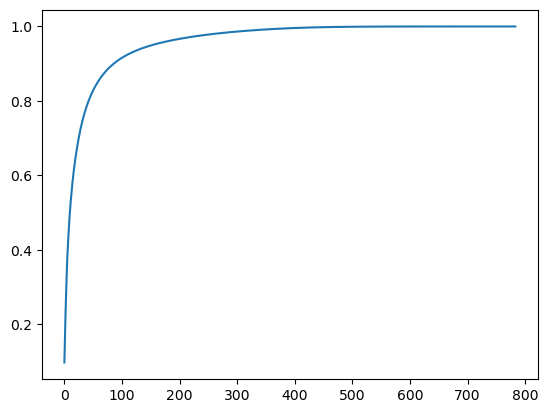

In [265]:
var_exp_thresh = 0.9
total_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.plot(total_var_exp);
pcindex = np.where(total_var_exp>=var_exp_thresh)[0]
print(f'take up to PC {pcindex[0]} to get to {var_exp_thresh}% variance explained')


### Task 4a: Clustering model selection in sample via elbow methods

In [107]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']

from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, make_scorer

clust = DBSCAN();
scale = StandardScaler();
pca = PCA(n_components=2);

# lets see how a pipeline allows us to stack operations!
pipe_pca = Pipeline([('scaler',scale), ('pca',pca)])

# a two step version
pcs = pd.DataFrame( PCA(n_components=2).fit_transform( scale.fit_transform(X) ), columns=['pc1', 'pc2'])
pcs['species'] = penguins['species']
sns.scatterplot(data=pcs, x='pc1', y='pc2', hue='species');
plt.title('two steps')
plt.show();

# a one step version of the same
pcs = pd.DataFrame( pipe_pca.fit_transform(X), columns=['pc1', 'pc2'])
pcs['species'] = penguins['species']
sns.scatterplot(data=pcs, x='pc1', y='pc2', hue='species');
plt.title('one step, same result');


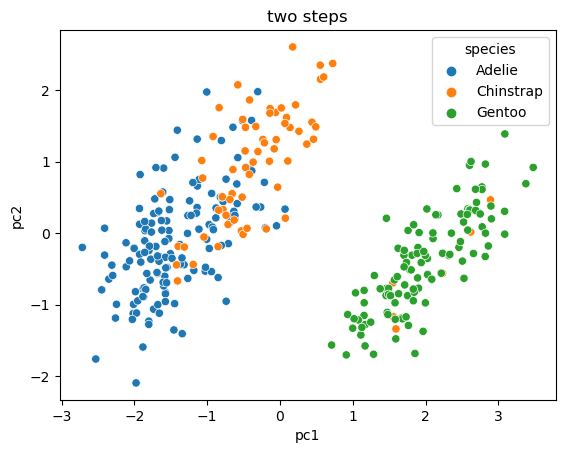

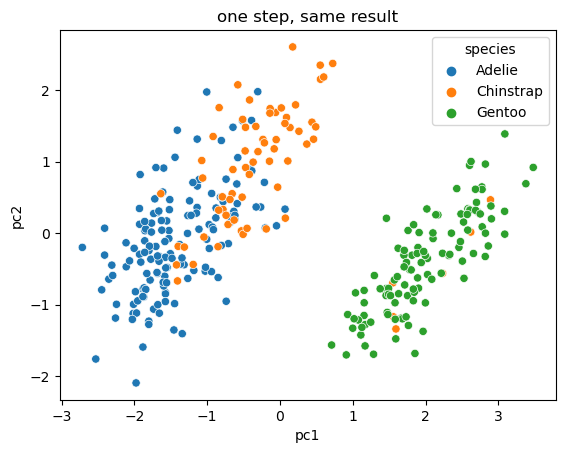

A rule of thumb for selecting good params for DBSCAN

1. Select min_samples such that it's at least 2*number of dimensions.  Even more if the data is "noisy"
1. Select eps such that you take the "elbow" of the distance to min_samples neighbors

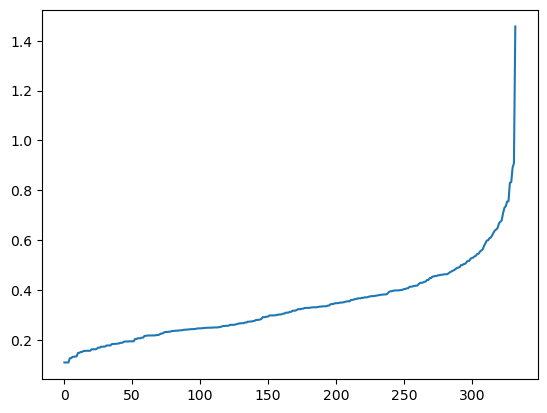

In [229]:
from sklearn.neighbors import NearestNeighbors
Xscaled = StandardScaler().fit_transform(X) 
neighbors = NearestNeighbors(n_neighbors=15)
neighbors.fit( Xscaled )
distances, indices = neighbors.kneighbors(Xscaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

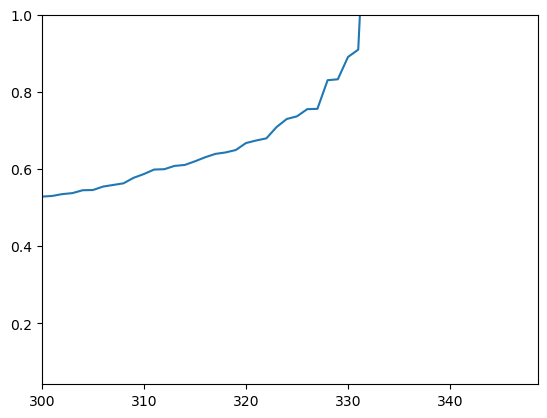

In [231]:
# zoom in on the elbow!!!
plt.plot(distances);
plt.xlim(left=..., right=...);
plt.ylim(top=..., bottom=...);

In [240]:
clust = DBSCAN(eps= ..., min_samples= ...);
pipe_clust = Pipeline([('scaler',scale), ('clustering',clust)])
predictions = pipe_clust.fit_predict(X)
print(f'ARI: {adjusted_rand_score(y,predictions)}')
pcs['predicted'] = predictions
sns.scatterplot(data=pcs, x='pc1', y='pc2', hue='predicted', palette='Set2');

Pipeline(steps=[('scaler', StandardScaler()),
                ('clustering', DBSCAN(eps=0.7, min_samples=16))])

Now that you've seen the "recipe" you can of course go back and play with the hyperparameters until you get something that looks "better" to you.   What is the risk of doing so?  How can you fool yourself?

<!-- eps=7e-1, min_samples-16 -->

### Task 4b: Dimensionality reduction plus clustering model selection using cross validation with ground truth

In [3]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, make_scorer
from sklearn.pipeline import Pipeline

# this is one possible scoring function for Grid Search
# this only works for clustering algo like GMM that have a .bic() method
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# this is another possible scoring function for Grid Search
# it only works for datasets where there is actually a ground truth!
ari_score = make_scorer(adjusted_rand_score)


clust = GaussianMixture()
scale = StandardScaler();

# previously via elbow methods we saw that we could pick PCs around 80
pca = PCA(n_components=80);

# lets see how a pipeline allows us to stack operations!
pipe_pca_cl = Pipeline([('scaler',scale), ('pca',pca), ('clustering', clust)])


# WARNING! this takes > 20 min on my laptop
params = {'clustering__n_components': np.arange(8,12), 
          'clustering__covariance_type': ['full', 'spherical']}

# also try doing this with gmm_bic_score and see if its different!
grid = GridSearchCV(estimator=pipe_pca_cl, 
                    param_grid=params, 
                    scoring=ari_score,  #replace with bic? if so you probably have to remove the target during fit: ie, grid.fit(mnist.data)
                    verbose=3,
                    cv=3 # 3-fold cross validation!
                   )

In [280]:
grid.fit(mnist.data, mnist.target)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END clustering__covariance_type=full, clustering__n_components=8;, score=0.202 total time=  37.2s
[CV 2/3] END clustering__covariance_type=full, clustering__n_components=8;, score=0.212 total time=  25.1s
[CV 3/3] END clustering__covariance_type=full, clustering__n_components=8;, score=0.206 total time=  44.9s


/Users/jasonfleischer/opt/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV 1/3] END clustering__covariance_type=full, clustering__n_components=9;, score=0.191 total time=  52.9s
[CV 2/3] END clustering__covariance_type=full, clustering__n_components=9;, score=0.226 total time=  34.6s


/Users/jasonfleischer/opt/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV 3/3] END clustering__covariance_type=full, clustering__n_components=9;, score=0.199 total time=  51.5s
[CV 1/3] END clustering__covariance_type=full, clustering__n_components=10;, score=0.220 total time=  35.2s
[CV 2/3] END clustering__covariance_type=full, clustering__n_components=10;, score=0.210 total time=  42.9s
[CV 3/3] END clustering__covariance_type=full, clustering__n_components=10;, score=0.209 total time=  44.6s
[CV 1/3] END clustering__covariance_type=full, clustering__n_components=11;, score=0.210 total time=  42.8s
[CV 2/3] END clustering__covariance_type=full, clustering__n_components=11;, score=0.229 total time=  37.1s
[CV 3/3] END clustering__covariance_type=full, clustering__n_components=11;, score=0.207 total time=  27.8s
[CV 1/3] END clustering__covariance_type=spherical, clustering__n_components=8;, score=0.215 total time=   5.4s
[CV 2/3] END clustering__covariance_type=spherical, clustering__n_components=8;, score=0.213 total time=   5.8s
[CV 3/3] END clusteri

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=80)),
                                       ('clustering', GaussianMixture())]),
             param_grid={'clustering__covariance_type': ['full', 'spherical'],
                         'clustering__n_components': array([ 8,  9, 10, 11])},
             scoring=make_scorer(adjusted_rand_score), verbose=3)

covariance_type  n_components     score
0            full             8  0.206721
1            full             9  0.205187
2            full            10  0.213029
3            full            11  0.215158
4       spherical             8  0.215352
5       spherical             9  0.214842
6       spherical            10  0.213089
7       spherical            11  0.220038

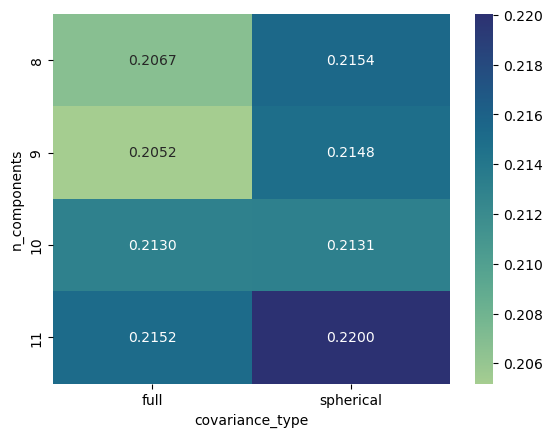

In [283]:
results = pd.DataFrame( grid.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we could use 1 - x
results['score'] = grid.cv_results_['mean_test_score']

# get rid of clustering__XX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results across penalty & C values
sns.heatmap( results.pivot('n_components','covariance_type','score'),
             annot=True, fmt='5.4f', cmap="crest")

results


#### This time optimizing multiple steps of the pipeline

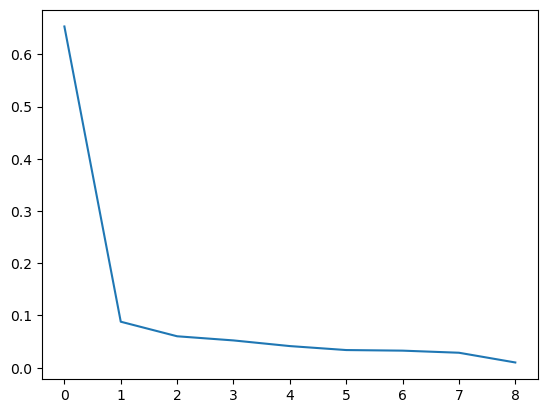

In [27]:
pca = PCA()
dataset = cancer.data.join(cancer.target)
dataset = dataset.dropna()
data = dataset.drop(columns=['id','class'])
data = StandardScaler().fit_transform(data)
target = dataset['class']

red = pca.fit_transform( data )
plt.plot(pca.explained_variance_ratio_); 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END clustering__n_clusters=1, pca__n_components=1;, score=0.000 total time=   0.0s
[CV 2/5] END clustering__n_clusters=1, pca__n_components=1;, score=0.000 total time=   0.0s
[CV 3/5] END clustering__n_clusters=1, pca__n_components=1;, score=0.000 total time=   0.0s
[CV 4/5] END clustering__n_clusters=1, pca__n_components=1;, score=0.000 total time=   0.0s
[CV 5/5] END clustering__n_clusters=1, pca__n_components=1;, score=0.000 total time=   0.0s
[CV 1/5] END clustering__n_clusters=1, pca__n_components=2;, score=0.000 total time=   0.0s
[CV 2/5] END clustering__n_clusters=1, pca__n_components=2;, score=0.000 total time=   0.0s
[CV 3/5] END clustering__n_clusters=1, pca__n_components=2;, score=0.000 total time=   0.0s
[CV 4/5] END clustering__n_clusters=1, pca__n_components=2;, score=0.000 total time=   0.0s
[CV 5/5] END clustering__n_clusters=1, pca__n_components=2;, score=0.000 total time=   0.0s
[CV 1/5] END clust

[CV 2/5] END clustering__n_clusters=3, pca__n_components=1;, score=0.676 total time=   0.0s
[CV 3/5] END clustering__n_clusters=3, pca__n_components=1;, score=0.726 total time=   0.0s
[CV 4/5] END clustering__n_clusters=3, pca__n_components=1;, score=0.851 total time=   0.0s
[CV 5/5] END clustering__n_clusters=3, pca__n_components=1;, score=0.877 total time=   0.0s
[CV 1/5] END clustering__n_clusters=3, pca__n_components=2;, score=0.662 total time=   0.0s
[CV 2/5] END clustering__n_clusters=3, pca__n_components=2;, score=0.721 total time=   0.0s
[CV 3/5] END clustering__n_clusters=3, pca__n_components=2;, score=0.781 total time=   0.0s
[CV 4/5] END clustering__n_clusters=3, pca__n_components=2;, score=0.911 total time=   0.0s
[CV 5/5] END clustering__n_clusters=3, pca__n_components=2;, score=0.944 total time=   0.0s
[CV 1/5] END clustering__n_clusters=3, pca__n_components=3;, score=0.662 total time=   0.0s
[CV 2/5] END clustering__n_clusters=3, pca__n_components=3;, score=0.721 total t

n_clusters  n_components     score
0            1             1  0.000000
1            1             2  0.000000
2            1             3  0.000000
3            1             4  0.000000
4            1             5  0.000000
5            1             6  0.000000
6            1             7  0.000000
7            1             8  0.000000
8            1             9  0.000000
9            2             1  0.842312
10           2             2  0.837695
11           2             3  0.848051
12           2             4  0.854790
13           2             5  0.854790
14           2             6  0.854790
15           2             7  0.842312
16           2             8  0.854790
17           2             9  0.854790
18           3             1  0.758326
19           3             2  0.803823
20           3             3  0.796901
21           3             4  0.798288
22           3             5  0.783087
23           3             6  0.798288
24           3             7  0.782052
25           3             8  0.783557
26           3             9  0.787129
27           4             1  0.739086
28           4             2  0.735231
29           4             3  0.747833
30           4             4  0.747542
31           4             5  0.748563
32           4             6  0.749266
33           4             7  0.745395
34           4             8  0.742194
35           4             9  0.742704

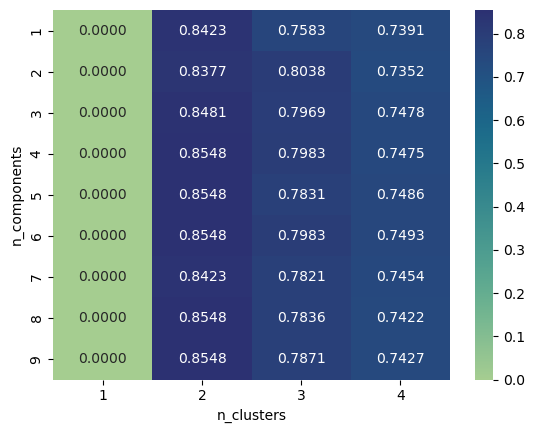

In [28]:
# elbow method suggests pc around 3, but lets try em all
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, make_scorer

ari_score = make_scorer(adjusted_rand_score)


clust = KMeans()
scale = StandardScaler()
pca = PCA();

# lets see how a pipeline allows us to stack operations!
pipe_pca_cl = Pipeline([('scaler',scale), ('pca',pca), ('clustering', clust)])


params = {'pca__n_components': np.arange(1,10), 
          'clustering__n_clusters': np.arange(1,5)}


grid = GridSearchCV(estimator=pipe_pca_cl, 
                    param_grid=params, 
                    scoring=ari_score, 
                    verbose=3,
                    cv=5 # 3-fold cross validation!
                   )

grid.fit(data, target)

results = pd.DataFrame( grid.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we could use 1 - x
results['score'] = grid.cv_results_['mean_test_score']

# get rid of clustering__XX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results across penalty & C values
sns.heatmap( results.pivot('n_components','n_clusters','score'),
             annot=True, fmt='5.4f', cmap="crest")

results


### Task 5: Outlier detection


Your turn!

Take a dataset, make a train test split... eliminate a class from the training set (like no 0s from mnist).... 
 
do a PCA.fit( trainingset)
then do a PCA.transform( testset) <-- no fit here!!!!

plot the transformed data and color in the outlier class to see that it clusters differently 